In [5]:
import pandas as pd
import random
from faker import Faker
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# Initialize Faker instance
fake = Faker()

# Generate Customer Demographics Data
def generate_customer_demographics(num_customers=1000):
    customer_data = []
    for _ in range(num_customers):
        customer = {
            'customer_id': fake.uuid4(),
            'name': fake.name(),
            'age': random.randint(18, 70),
            'gender': random.choice(['Male', 'Female']),
            'marital_status': random.choice(['Single', 'Married', 'Divorced']),
            'education': random.choice(['High School', 'Bachelor', 'Master', 'PhD']),
            'occupation': fake.job(),
            'salary': random.randint(20000, 150000),  # Yearly salary
        }
        customer_data.append(customer)
    return pd.DataFrame(customer_data)

# Generate Customer Financial Behavior Data
def generate_financial_behavior(customer_ids, num_records=2000):
    financial_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        loan_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 150000)
        credit_limit = random.randint(1000, 150000) if product_type == 'Credit Card' else None
        utilization = random.uniform(0.1, 1.0) if product_type == 'Credit Card' else None
        max_dpd = random.choice([0, 15, 30, 60, 90, 120])
        default_status = random.choice([True, False])

        financial_behavior = {
            'customer_id': random.choice(customer_ids),
            'product_type': product_type,
            'loan_amount': loan_amount,
            'credit_limit': credit_limit,
            'credit_utilization': utilization,
            'emi_paid': random.randint(1, 24),
            'tenure_months': random.randint(12, 60),
            'max_dpd': max_dpd,
            'default_status': default_status
        }
        financial_data.append(financial_behavior)
    return pd.DataFrame(financial_data)

# Generate Customer Enquiries Data (Last 3 months)
def generate_customer_enquiries(customer_ids, num_records=500):
    enquiries_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        enquiry_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 100000)
        enquiry = {
            'customer_id': random.choice(customer_ids),
            'enquiry_date': fake.date_between(start_date='-90d', end_date='today'),
            'product_type': product_type,
            'enquiry_amount': enquiry_amount,
            'status': random.choice(['Approved', 'Rejected'])
        }
        enquiries_data.append(enquiry)
    return pd.DataFrame(enquiries_data)

# Generate Customer Transaction Data (Past 6 months)
def generate_customer_transactions(customer_ids, num_records=5000):
    transactions_data = []
    for _ in range(num_records):
        transaction_date = fake.date_between(start_date='-180d', end_date='today')
        transaction_amount = random.uniform(50, 10000)
        
        # Transaction description with salary-related and hobby keywords
        transaction_description = random.choice([
            'Salary from XYZ Corp', 'Amazon Purchase', 'Grocery Store', 'Gym Membership',
            'Netflix Subscription', 'Restaurant', 'Fuel Station', 'Travel Booking', 
            'SALARY - ABC Corp', 'SAL credited from DEF Ltd', 'Monthly Salary GHI Pvt Ltd', 
            'Rent Payment', 'Car Insurance', 'Mobile Phone Bill', 'Electricity Bill', 'Spotify Subscription',
            'Uber Ride', 'Etsy Shopping', 'Concert Ticket', 'Books Purchase'
        ])

        # Salary detection
        salary_keywords = ['Salary', 'SALARY', 'SAL', 'SAL credited', 'Monthly Salary']
        is_salary = any(keyword in transaction_description.upper() for keyword in salary_keywords)

        # Hobbies detection based on transaction descriptions
        hobbies = None
        if "Amazon" in transaction_description or "Etsy" in transaction_description:
            hobbies = 'Shopping'
        elif "Netflix" in transaction_description or "Spotify" in transaction_description:
            hobbies = 'Entertainment'
        elif "Gym" in transaction_description:
            hobbies = 'Fitness'
        elif "Concert" in transaction_description:
            hobbies = 'Music'
        elif "Books" in transaction_description:
            hobbies = 'Reading'
        elif "Travel" in transaction_description or "Uber Ride" in transaction_description:
            hobbies = 'Travel'

        transaction = {
            'customer_id': random.choice(customer_ids),
            'transaction_date': transaction_date,
            'transaction_amount': transaction_amount,
            'transaction_description': transaction_description,
            'account_balance': random.uniform(500, 20000),
            'is_salary': is_salary,
            'hobby_detected': hobbies
        }
        transactions_data.append(transaction)

    return pd.DataFrame(transactions_data)

# Generate consistent data across all categories
customers = generate_customer_demographics(5000)
financial_behavior = generate_financial_behavior(customers['customer_id'], num_records=15000)
enquiries = generate_customer_enquiries(customers['customer_id'], num_records=4000)
transactions = generate_customer_transactions(customers['customer_id'], num_records=20000)

In [6]:
# Combine Data for Clustering
# Aggregating financial and transaction data by customer_id to create summary features
financial_summary = financial_behavior.groupby('customer_id').agg({
    'loan_amount': 'mean',
    'credit_limit': 'mean',
    'credit_utilization': 'mean',
    'emi_paid': 'sum',
    'tenure_months': 'mean',
    'max_dpd': 'max',
    'default_status': 'mean',
    'product_type':'unique'
}).reset_index()

transaction_summary = transactions.groupby('customer_id').agg({
    'transaction_amount': 'mean',
    'account_balance': 'mean',
    'is_salary': 'sum',
    'transaction_amount': lambda x: x[transactions['is_salary'] == 1].sum()
}).reset_index()

# Assuming 'enquiries' has columns like ['customer_id', 'product_type', 'enquiry_date', 'enquiry_amount']
enquiries_summary = enquiries.groupby('customer_id').agg({
    'enquiry_amount': 'mean',  # Average amount enquired
    'product_type': lambda x: x.nunique(),  # Number of unique products enquired
    'customer_id': 'count'  # Total number of enquiries
}).rename(columns={
    'customer_id': 'total_enquiries',
    'product_type': 'unique_products_enquired'
}).reset_index()

# Merging demographics, financial behavior, and transaction summary
merged_data = pd.merge(customers, financial_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, enquiries_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, transaction_summary, on='customer_id', how='left')

In [7]:
# Step 1: Explode the list in 'product_type' column
df_exploded = merged_data.explode('product_type')

# Step 2: One-hot encode the 'product_type' column
df_encoded = pd.get_dummies(df_exploded['product_type'])

merged_data = pd.concat([df_exploded, df_encoded], axis=1)

# Step 4: Group by the original index and aggregate to bring it back into one row per customer
df_final = merged_data.groupby(merged_data.index).sum()
df_final.columns

Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
       'occupation', 'salary', 'loan_amount', 'credit_limit',
       'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
       'default_status', 'product_type', 'enquiry_amount',
       'unique_products_enquired', 'total_enquiries', 'transaction_amount',
       'account_balance', 'is_salary', 'Credit Card', 'Home Loan',
       'Personal Loan'],
      dtype='object')

In [8]:
# Define the aggregation function for each column
aggregation_functions = {
    'customer_id': 'first',  # Keep first occurrence (assuming it's the same for the group)
    'name': 'first',         # Keep the first name in each group
    'age': 'mean',           # For age, you can take the average or median
    'gender': 'first',       # Assuming gender is the same within each group, take the first
    'marital_status': 'first', # Same for marital status
    'education': 'first',    # Same for education
    'occupation': 'first',   # Same for occupation
    'salary': 'sum',         # Sum numerical values like salary
    'loan_amount': 'sum',    # Sum numerical values like loan amount
    'credit_limit': 'sum',   # Sum numerical values like credit limit
    'credit_utilization': 'sum',
    'emi_paid':'sum',
    'tenure_months':'sum',
    'max_dpd':'max',
    'default_status':'max',
    'enquiry_amount': 'sum',
    'unique_products_enquired': 'sum',
    'total_enquiries': 'sum',
    'transaction_amount': 'sum',
    'account_balance': 'sum',
    'is_salary': 'mean',     # For boolean-like columns, you can take the mean (0 or 1)
    'Credit Card': 'max',    # For categorical (binary) features, take max (0 or 1)
    'Home Loan': 'max',
    'Personal Loan': 'max',
}

# Group by and apply aggregation functions
df_final = merged_data.groupby(merged_data.index).agg(aggregation_functions)
df_final.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan
0,9a259e97-8cf2-4144-a475-be6ec4e37d41,Natalie Rogers,64.0,Male,Married,PhD,Restaurant manager,169866,438290.000000,82412.000000,...,0.666667,0.0,0.0,0.0,4767.170557,21712.959985,2.0,True,True,False
1,dc797747-38eb-4c73-b057-5a16e8956c3d,Ryan Wyatt,45.0,Male,Divorced,Master,Research scientist (maths),402489,852013.500000,440757.000000,...,0.750000,197814.0,3.0,3.0,0.000000,34595.100993,0.0,True,True,True
2,c512bc56-0e91-4dc3-a1d6-4127bcc6bb5f,Amy Mills,18.0,Female,Single,Master,Historic buildings inspector/conservation officer,236498,165930.000000,86306.666667,...,0.500000,95192.0,2.0,2.0,13812.619085,19891.962835,2.0,True,True,False
3,876f7cfb-07ce-4baf-9a5f-8f8b1d840902,Miguel Rocha,54.0,Female,Single,Master,Minerals surveyor,40661,36732.666667,72588.666667,...,0.333333,63022.0,1.0,1.0,0.000000,16269.165721,0.0,True,False,False
4,438202c3-96f5-4f09-8c21-530ff050226a,Casey Mayer,19.0,Male,Divorced,PhD,Commercial horticulturist,133953,725178.000000,63840.000000,...,0.500000,597606.0,3.0,3.0,8480.647434,33563.923024,1.0,True,True,True


Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan'],
      dtype='object')


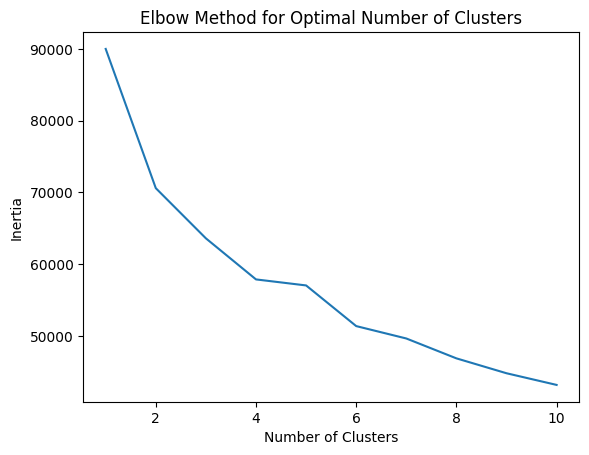

                            customer_id  customer_segment
0  9a259e97-8cf2-4144-a475-be6ec4e37d41                 1
1  dc797747-38eb-4c73-b057-5a16e8956c3d                 2
2  c512bc56-0e91-4dc3-a1d6-4127bcc6bb5f                 1
3  876f7cfb-07ce-4baf-9a5f-8f8b1d840902                 0
4  438202c3-96f5-4f09-8c21-530ff050226a                 2


In [9]:
# Drop irrelevant columns for clustering
clustering_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
print(clustering_data.columns)
# Handle missing values
clustering_data.fillna(0, inplace=True)
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Determine optimal number of clusters (elbow method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal K (say K=4 based on the elbow curve)
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['customer_segment'] = kmeans.fit_predict(scaled_data)

# View segmented data
print(df_final[['customer_id', 'customer_segment']].head())

In [10]:
pd.set_option('display.max_columns', None)
# Assuming df_final is your DataFrame and 'customer_segment' is the column to group by
float_columns = df_final.select_dtypes(include=['int','float'])
grouped_df = float_columns.groupby('customer_segment')

# Summary of each segment
segment_description = grouped_df.describe()
segment_description

age                                                      \
                   count       mean        std   min   25%   50%   75%   max   
customer_segment                                                               
0                 1544.0  44.325130  15.144985  18.0  31.0  44.0  57.0  70.0   
1                 2264.0  43.523410  15.260628  18.0  30.0  43.0  57.0  70.0   
2                 1192.0  43.459732  15.176158  18.0  31.0  43.0  57.0  70.0   

                  salary                                                   \
                   count           mean            std      min       25%   
customer_segment                                                            
0                 1544.0   86335.855570   37944.945764  20168.0   54230.0   
1                 2264.0  169033.850707   77263.934194  40086.0  103566.0   
2                 1192.0  265911.377517  111097.108150  51718.0  173143.5   

                                                loan_amount                 \
                       50%        75%       max       count           mean   
customer_segment                                                             
0                  86432.0  118224.50  293214.0      1544.0  161349.524557   
1                 165673.0  233866.50  433197.0      2264.0  394522.485856   
2                 269179.5  365925.75  449412.0      1192.0  590816.178327   

                                                                          \
                            std        min            25%            50%   
customer_segment                                                           
0                 142386.590089       0.00   39082.666667  121768.500000   
1                 173584.902138   14126.00  262987.400000  385715.333333   
2                 185825.950887  132116.25  468022.350000  587146.028571   

                                        credit_limit                 \
                         75%        max        count           mean   
customer_segment                                                      
0                 266354.000   749226.0       1544.0   21080.098230   
1                 511298.500   969578.0       2264.0  104319.712934   
2                 716157.225  1104892.5       1192.0  234170.280062   

                                                                   \
                            std     min        25%            50%   
customer_segment                                                    
0                  39763.559373     0.0       0.00       0.000000   
1                  94386.822725     0.0       0.00   98323.333333   
2                 109077.674468  3951.0  153144.25  235017.750000   

                                          credit_utilization            \
                            75%       max              count      mean   
customer_segment                                                         
0                  20735.250000  214602.0             1544.0  0.151535   
1                 179265.666667  416268.0             2264.0  0.769763   
2                 316247.250000  449244.0             1192.0  1.705882   

                                                                              \
                       std       min       25%       50%       75%       max   
customer_segment                                                               
0                 0.282319  0.000000  0.000000  0.000000  0.213672  1.960283   
1                 0.646917  0.000000  0.000000  0.807309  1.274968  2.979385   
2                 0.685914  0.303275  1.191482  1.744026  2.229791  2.996743   

                 emi_paid                                                    \
                    count        mean        std   min    25%    50%    75%   
customer_segment                                                              
0                  1544.0   16.948834  15.488355   0.0    4.0   15.0   24.0   
1                  2264.0   82.113958  40.416811   4.0   52.0   76.

In [11]:
# Preparing data for regression model (predicting loan amount)
# Drop non-numerical and unnecessary columns for regression
regression_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
regression_data.fillna(-888, inplace=True)

# Define models for each product type
rf_regressor_personal_loan = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_home_loan = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_credit_card = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model for Personal Loan
X_personal_loan = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 1)].drop(columns=['loan_amount'])
y_personal_loan = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 1)]['loan_amount']
X_train_personal_loan, X_test_personal_loan, y_train_personal_loan, y_test_personal_loan = train_test_split(X_personal_loan, y_personal_loan, test_size=0.2, random_state=42)
rf_regressor_personal_loan.fit(X_personal_loan, y_personal_loan)

# Train the model for Home Loan
X_home_loan = regression_data[(regression_data['Home Loan'] == 1) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 0)].drop(columns=['loan_amount'])
y_home_loan = regression_data[(regression_data['Home Loan'] == 1) & (regression_data['Credit Card']== 0) & (regression_data['Personal Loan']== 0)]['loan_amount']
X_train_home_loan, X_test_home_loan, y_train_home_loan, y_test_home_loan = train_test_split(X_home_loan, y_home_loan, test_size=0.2, random_state=42)
rf_regressor_home_loan.fit(X_train_home_loan, y_train_home_loan)

# Train the model for Credit Card
X_credit_card = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 1) & (regression_data['Personal Loan']== 0)].drop(columns=['loan_amount'])
y_credit_card = regression_data[(regression_data['Home Loan'] == 0) & (regression_data['Credit Card']== 1) & (regression_data['Personal Loan']== 0)]['loan_amount']
X_train_credit_card, X_test_credit_card, y_train_credit_card, y_test_credit_card = train_test_split(X_credit_card, y_credit_card, test_size=0.2, random_state=42)
rf_regressor_credit_card.fit(X_train_credit_card, y_train_credit_card)

# Predict on test set
y_pred = rf_regressor_credit_card.predict(X_test_credit_card)

# Evaluate the model
mse = mean_squared_error(y_test_credit_card, y_pred)
print(f"Mean Squared Error: {mse}")

# Example: Making predictions for a new customer
new_customer_data = X_test_credit_card.iloc[0:1]  # Select one customer data for testing
predicted_loan_amount = rf_regressor_credit_card.predict(new_customer_data)
print(f"Predicted Loan Amount: {predicted_loan_amount[0]}")

Mean Squared Error: 1438497757.2676573
Predicted Loan Amount: 69480.84833333334


In [12]:
# Assuming df_final is already defined
# Preparing data for classification model
classification_data = df_final.copy()
classification_data.fillna(-888, inplace=True)
# Step 2: Drop unnecessary columns for the model and target columns
X_classification = classification_data.drop(columns=['customer_id', 'name', 'occupation', 'gender', 
                                                     'marital_status', 'education', 'Credit Card', 'Home Loan', 'Personal Loan'])
y_classification = classification_data[['Credit Card', 'Home Loan', 'Personal Loan']]  # Multi-output target columns

# Step 3: Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Initialize Random Forest Classifier with MultiOutputClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier = MultiOutputClassifier(rf_classifier)

# Step 5: Train the model on the training data for all three outputs
multi_target_classifier.fit(X_train_class, y_train_class)

# Step 6: Predict probabilities for the test set
y_prob_test = [estimator.predict_proba(X_test_class)[:, 1] for estimator in multi_target_classifier.estimators_]

# Combine probabilities into a DataFrame for easier handling
probabilities = pd.DataFrame({
    'Credit Card': y_prob_test[0],   # Probability for Credit Card
    'Home Loan': y_prob_test[1],     # Probability for Home Loan
    'Personal Loan': y_prob_test[2]  # Probability for Personal Loan
})

# Step 7: Find the most probable product for each customer
most_probable_product = probabilities.idxmax(axis=1)

# Optional: Evaluate model performance
y_pred = multi_target_classifier.predict(X_test_class)
print("\nClassification Report for Credit Card:")
print(classification_report(y_test_class['Credit Card'], y_pred[:, 0]))

print("\nClassification Report for Home Loan:")
print(classification_report(y_test_class['Home Loan'], y_pred[:, 1]))

print("\nClassification Report for Personal Loan:")
print(classification_report(y_test_class['Personal Loan'], y_pred[:, 2]))


Classification Report for Credit Card:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       387
        True       1.00      1.00      1.00       613

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Classification Report for Home Loan:
              precision    recall  f1-score   support

       False       0.68      0.66      0.67       375
        True       0.80      0.81      0.80       625

    accuracy                           0.75      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.75      0.75      0.75      1000


Classification Report for Personal Loan:
              precision    recall  f1-score   support

       False       0.70      0.64      0.67       334
        True       0.83      0.86      0.84       666

    accuracy                           0.79      1000
   macro

In [13]:
import joblib

# Define the file paths for saving
model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

# Save models to disk
joblib.dump(kmeans, model_paths['kmeans'])
joblib.dump(scaler, model_paths['scaler'])
joblib.dump(multi_target_classifier, model_paths['multi_target_classifier'])
joblib.dump(rf_regressor_personal_loan, model_paths['rf_regressor_personal_loan'])
joblib.dump(rf_regressor_home_loan, model_paths['rf_regressor_home_loan'])
joblib.dump(rf_regressor_credit_card, model_paths['rf_regressor_credit_card'])

print("Models saved successfully!")

Models saved successfully!


In [14]:
model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

kmeans = joblib.load(model_paths['kmeans'])
scaler = joblib.load(model_paths['scaler'])
multi_target_classifier = joblib.load(model_paths['multi_target_classifier'])
rf_regressor_personal_loan = joblib.load(model_paths['rf_regressor_personal_loan'])
rf_regressor_home_loan = joblib.load(model_paths['rf_regressor_home_loan'])
rf_regressor_credit_card = joblib.load(model_paths['rf_regressor_credit_card'])

print("Models loaded successfully!")


def process_customer_data(json_data, scaler):
    # Convert JSON data to a DataFrame
    customer_data = pd.DataFrame([json_data])
    
    # Drop columns not needed for clustering (based on your clustering model)
    clustering_data = customer_data
    
    # Handle missing values by replacing with 0 (or any appropriate strategy)
    clustering_data.fillna(0, inplace=True)
    
    scaled_data = scaler.transform(clustering_data)
    
    return customer_data, scaled_data

def predict_customer_segment(scaled_data, kmeans):
    # Predict the customer segment using your pre-trained KMeans model
    customer_segment = kmeans.predict(scaled_data)
    return customer_segment[0]

def recommend_product_and_loan(json_data, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card):
    # Convert JSON data to a DataFrame and scale the data
    customer_data, scaled_data = process_customer_data(json_data, scaler)

    # Step 1: Predict customer segment using KMeans
    customer_segment = predict_customer_segment(scaled_data, kmeans)
    
    # Add the predicted customer segment back to the customer_data DataFrame
    customer_data['customer_segment'] = customer_segment
    print(customer_data.columns)
    # Prepare for product recommendation using Random Forest Classifier
    X_classification_prod = customer_data.drop(columns=['Credit Card', 'Home Loan', 'Personal Loan'])
    X_classification_amt = customer_data
    
    # Step 2: Predict probabilities for each product using the multi-output classifier
    prob_credit_card = [estimator.predict_proba(X_classification_prod)[:, 1] for estimator in multi_target_classifier.estimators_]

    # Combine probabilities into a Series
    product_probabilities = pd.Series({
        'Credit Card': prob_credit_card[0][0],  # Since it's for one customer, we get the first value
        'Home Loan': prob_credit_card[1][0],
        'Personal Loan': prob_credit_card[2][0]
    })

    print(product_probabilities)
    
    # Identify the most probable product
    recommended_product = product_probabilities.idxmax()    
    recommended_probability = product_probabilities.max()

    recommendation = f"Recommended Product: {recommended_product} (Probability: {recommended_probability:.2f})"

    # Step 3: Predict loan amounts or credit limits based on the recommended product
    if recommended_product == 'Personal Loan':
        predicted_loan_amount_personal = rf_regressor_personal_loan.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_personal[0]:,.2f}"
    
    elif recommended_product == 'Home Loan':
        predicted_loan_amount_home = rf_regressor_home_loan.predict(X_classification_amt.drop(columns=['loan_amount']))  
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_home[0]:,.2f}"
    
    elif recommended_product == 'Credit Card':
        predicted_credit_limit = rf_regressor_credit_card.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Credit Limit: {predicted_credit_limit[0]:,.2f}"
    
    if recommended_probability < 0.5:
        recommendation = "No suitable product recommendations found for this customer."
    
    return recommendation, customer_segment, product_probabilities

# Example customer JSON data
example_json = {
    'age': 35, 'salary': 50000, 'loan_amount': 0, 'credit_limit': 10000, 
    'credit_utilization': 0.3, 'emi_paid': 1000, 'tenure_months': 12, 
    'max_dpd': 30, 'default_status': 0, 'enquiry_amount': 1000, 
    'unique_products_enquired': 3, 'total_enquiries': 5, 
    'transaction_amount': 5000, 'account_balance': 15000, 'is_salary': 1,
    'Credit Card': 1, 'Home Loan': 0, 'Personal Loan': 0, 
}

# Example usage:
recommend_product_and_loan(example_json, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card)

Models loaded successfully!
Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan', 'customer_segment'],
      dtype='object')
Credit Card      0.96
Home Loan        0.47
Personal Loan    0.45
dtype: float64


('Recommended Product: Credit Card (Probability: 0.96)\nPredicted Credit Limit: 86,304.58',
 2,
 Credit Card      0.96
 Home Loan        0.47
 Personal Loan    0.45
 dtype: float64)

In [20]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.llms import HuggingFacePipeline
from functools import lru_cache

@lru_cache(maxsize=None)
def load_model():
    model_name = "KingNish/Qwen2.5-0.5b-Test-ft"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model

# Function to generate insights based on customer data
# Function to generate insights based on customer data
def generate_insights(customer_data):
    tokenizer, model = load_model()

    # Create a prompt from the customer data
    prompt = f"""
    Generate a personalized summarised insight about the following customer based on their data:
    
    - Name: {customer_data['name']}
    - Age: {customer_data['age']}
    - Gender: {customer_data['gender']}
    - Marital Status: {customer_data['marital_status']}
    - Education: {customer_data['education']}
    - Occupation: {customer_data['occupation']}
    - Salary: ${customer_data['salary']:,.2f}
    - Loan Amount: ${customer_data['loan_amount']:,.2f}
    - Credit Limit: ${customer_data['credit_limit']:,.2f}
    - Credit Utilization: {customer_data['credit_utilization']:.2%}
    - EMI Paid: {customer_data['emi_paid']}
    - Tenure Months: {round(float(customer_data['tenure_months']),2)}
    - Max DPD: {customer_data['max_dpd']}
    - Default Status: {int(customer_data['default_status'])}
    - Account Balance: ${customer_data['account_balance']:,.2f}

    Here are the Summarised Insights about {customer_data['name']}:
    """
    # Initialize the query pipeline with increased max_length
    query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        max_length=6000,  # Increase max_length
        max_new_tokens=500,  # Control the number of new tokens generated
        device_map="auto",
    )

    llm = HuggingFacePipeline(pipeline=query_pipeline)

    insights = llm(prompt)
    return insights

In [21]:
import pandas as pd
import json

def df_row_to_json(row):
    data = row.to_dict()
    for key, value in data.items():
        if pd.isnull(value):
            data[key] = None
        elif isinstance(value, pd.Timestamp):
            data[key] = value.isoformat()

    # Convert to JSON string
    json_str = json.dumps(data, indent=4)
    return json_str

# Assuming `merged_data` is a DataFrame and we're converting row 8 to JSON
json_data_str = df_row_to_json(df_final.iloc[6])

# Now convert the JSON string back to a dictionary to access fields
json_data_dict = json.loads(json_data_str)

insights = generate_insights(json_data_dict)
print(json_data_str)
pd.DataFrame.from_dict(json_data_dict, orient='index').T

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/rashmiranjanswain/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(
/Users/rashmiranjanswain/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
Truncation was not explicitly activated but `max_length` is provided a specific va

{
    "customer_id": "7500fa60-54d2-4fdf-b1fa-5eaffdb34091",
    "name": "David Daniels",
    "age": 18.0,
    "gender": "Male",
    "marital_status": "Married",
    "education": "High School",
    "occupation": "Engineer, manufacturing",
    "salary": 144478,
    "loan_amount": 969578.0,
    "credit_limit": 0.0,
    "credit_utilization": 0.0,
    "emi_paid": 64.0,
    "tenure_months": 87.0,
    "max_dpd": 90.0,
    "default_status": 0.5,
    "enquiry_amount": 182612.0,
    "unique_products_enquired": 4.0,
    "total_enquiries": 4.0,
    "transaction_amount": 19903.038495343808,
    "account_balance": 11745.948074931097,
    "is_salary": 1.0,
    "Credit Card": false,
    "Home Loan": true,
    "Personal Loan": true,
    "customer_segment": 1
}


,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,credit_utilization,emi_paid,tenure_months,max_dpd,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan,customer_segment
0,7500fa60-54d2-4fdf-b1fa-5eaffdb34091,David Daniels,18.0,Male,Married,High School,"Engineer, manufacturing",144478,969578.0,0.0,0.0,64.0,87.0,90.0,0.5,182612.0,4.0,4.0,19903.038495,11745.948075,1.0,False,True,True,1


In [22]:
import re

# Function to clean unwanted characters and extract the insight
def clean_and_extract_insight(insights):
    # Remove unwanted characters (non-alphanumeric characters except spaces)
    cleaned_insight = re.sub(r'[^a-zA-Z0-9\s]', '', insights)
    
    # Extract the portion after "Summarised Insight"
    if "Here are the Summarised Insights about" in cleaned_insight:
        extracted_insight = cleaned_insight.split("Here are the Summarised Insights about")[1].strip().split("\n\n")[0]
    else:
        extracted_insight = cleaned_insight.strip()

    return extracted_insight

# Example usage
cleaned_insight = clean_and_extract_insight(insights)
print(cleaned_insight.strip())

David Daniels
      Income Statement
          Income 3212350
          Expenses 14447800
          Net Income 12235450
      Balance Sheet
          Assets 1174595 Current
          Liabilities 96957800 Current
          Owners Equity 84481205 Equity
      Credit Report
          FICO Score 760
          Negative Payment History No
          Credit History 01 Year No
          Credit Card History No
          Credit Reports None None
